# RNN - Insurance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel('../raw_data/weekly_data_clean.xlsx', engine='openpyxl')

In [3]:
data = data.drop(columns=['Unnamed: 0', 'date_issue'])

In [4]:
data

,total_amount_claims
0,16683
1,201774
2,263661
3,799703
4,900305
...,...
127,1949930
128,1725225
129,2232202
130,2666662


In [5]:
print("min: ",data['total_amount_claims'].min())
print("max: ",data['total_amount_claims'].max())

min:  16683
max:  2666662


In [6]:
data.shape

(132, 1)

In [7]:
min_ = data['total_amount_claims'].min()
max_ = data['total_amount_claims'].max()

data['total_amount_claims'] = [((x - min_) / (max_ - min_)) for x in data['total_amount_claims']]

In [8]:
data

,total_amount_claims
0,0.000000
1,0.069846
2,0.093200
3,0.295482
4,0.333445
...,...
127,0.729533
128,0.644738
129,0.836052
130,1.000000


### Split data

In [9]:
len_ = int(0.8*data.shape[0])

data_train = data[:len_]
data_test = data[len_:]

In [10]:
print(data_train.shape)
print(data_test.shape)

(105, 1)
(27, 1)


### Sequences

In [11]:
def subsample_sequence(data, length):
    
    last_possible = data.shape[0] - length
    
    random_start = np.random.randint(0, last_possible)
    data_sample = data[random_start: random_start+length]
    
    return data_sample

In [12]:
data_subsample = subsample_sequence(data, 10)
data_subsample

,total_amount_claims
112,0.466072
113,0.465067
114,0.461644
115,0.533537
116,0.460298
117,0.539930
118,0.477951
119,0.478536
120,0.479784
121,0.437053


In [13]:
def fillna(X, data_mean):
    # Replace with NaN of the other hours. 
    na = X.mean()
    
    # If the other hours are also nans, then replace with mean value of the dataframe
    na.fillna(data_mean)
    return na

def split_subsample_sequence(data, length, data_mean=None):
    # Little trick to improve the time
    if data_mean is None:
        data_mean = data.mean()
              
    data_subsample = subsample_sequence(data, length)
    y_sample = data_subsample.iloc[data_subsample.shape[0]-1]['total_amount_claims']
    
    if y_sample != y_sample: # A value is not equal to itself only for NaN. So it will be True if y_sample is nan
        X_sample, y_sample = split_subsample_sequence(data, length, data_mean)
        return np.array(X_sample), np.array(y_sample)
    
    X_sample = data_subsample[0:data_subsample.shape[0]-1]
    X_sample = X_sample.fillna(fillna(X_sample, data_mean))
    X_sample = X_sample.values
    
    return np.array(X_sample), np.array(y_sample)

In [14]:
def get_X_y(data, number_of_sequences, length):
    X, y = [], []

    for i in range(number_of_sequences):
        xi, yi = split_subsample_sequence(data, length)
        X.append(xi)
        y.append(yi)
        
    X = np.array(X)
    y = np.array(y)
        
    return X, y

In [15]:
X_train, y_train = get_X_y(data_train, 80, 10)
X_test, y_test = get_X_y(data_test, 20, 10)

In [16]:
# !pip install tensorflow

In [17]:
print(f'X train size:{X_train.shape}')
print(f'X test size:{X_test.shape}')
print(f'y train size:{y_train.shape}')
print(f'y test size:{y_test.shape}')

X train size:(80, 9, 1)
X test size:(20, 9, 1)
y train size:(80,)
y test size:(20,)


In [19]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()

model.add(layers.LSTM(20, activation='tanh'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='linear'))

In [20]:
model.compile(loss='mse', 
              optimizer='rmsprop', 
              metrics=['mse', 'mae', 'mape'])

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
            validation_split=0.2,
            epochs=100, 
            batch_size=16,
            callbacks=[es])

Epoch 1/100
4/4 [==============================] - 2s 194ms/step - loss: 0.0279 - mse: 0.0279 - mae: 0.1350 - mape: 64.2961 - val_loss: 0.0245 - val_mse: 0.0245 - val_mae: 0.1215 - val_mape: 52.1499
Epoch 2/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0094 - mse: 0.0094 - mae: 0.0685 - mape: 43.4883 - val_loss: 0.0170 - val_mse: 0.0170 - val_mae: 0.0993 - val_mape: 54.1688
Epoch 3/100
4/4 [==============================] - 0s 26ms/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0656 - mape: 50.3275 - val_loss: 0.0153 - val_mse: 0.0153 - val_mae: 0.0927 - val_mape: 55.6052
Epoch 4/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0076 - mse: 0.0076 - mae: 0.0714 - mape: 63.4956 - val_loss: 0.0152 - val_mse: 0.0152 - val_mae: 0.0922 - val_mape: 55.5320
Epoch 5/100
4/4 [==============================] - 0s 25ms/step - loss: 0.0058 - mse: 0.0058 - mae: 0.0643 - mape: 59.4906 - val_loss: 0.0143 - val_mse: 0.0143 - val_mae: 0.0882 - val_mape: 57.6045
Epoch 6/1

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (16, 20)                  1760      
_________________________________________________________________
dense (Dense)                (16, 5)                   105       
_________________________________________________________________
dense_1 (Dense)              (16, 1)                   6         
Total params: 1,871
Trainable params: 1,871
Non-trainable params: 0
_________________________________________________________________


In [23]:
model_eval = model.evaluate(X_test, y_test, verbose=0)
# print(f'Model Mean Absolute Error {model_eval[1]:.4f}')
# print(f'Model Mean Absolute Porcentual Error {model_eval[2]:.4f}')
model_eval

[0.05736522004008293,
 0.05736522004008293,
 0.20471462607383728,
 33.0782585144043]

In [24]:
# tf.keras.losses.MAPE(
#     y_true, y_pred
# )

#### Prediction

In [25]:
y_pred = model.predict(X_test)

In [26]:
y_pred.shape

(20, 1)

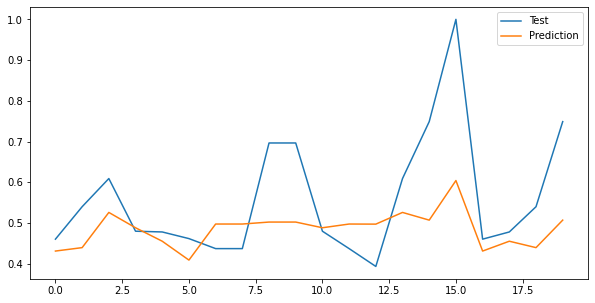

In [44]:
plt.figure(figsize=(10,5))
plt.plot(y_test,label = 'Test')
plt.plot(y_pred, label = 'Prediction')
plt.legend(loc='best')
plt.show()

# 

### Reversion

In [37]:
# def rev_min_max_func(scaled_val):
#     max_val = max(df['target'])
#     min_val = min(df['target'])
#     og_val = (scaled_val*(max_val - min_val)) + min_val
#     return og_val
# df['pred_target'] = scaled_labeled_df['pred_scaled_target'].apply(lambda x: rev_min_max_func(x))

In [40]:
data['total_amount_claims'] = [((x*(max_ - min_)) + min_) for x in data['total_amount_claims']]

In [41]:
data['total_amount_claims']

0        16683.0
1       201774.0
2       263661.0
3       799703.0
4       900305.0
         ...    
127    1949930.0
128    1725225.0
129    2232202.0
130    2666662.0
131    2111986.0
Name: total_amount_claims, Length: 132, dtype: float64

In [45]:
y_pred = [((x*(max_ - min_)) + min_) for x in y_pred]

In [27]:
y_pred.shape

(20, 1)

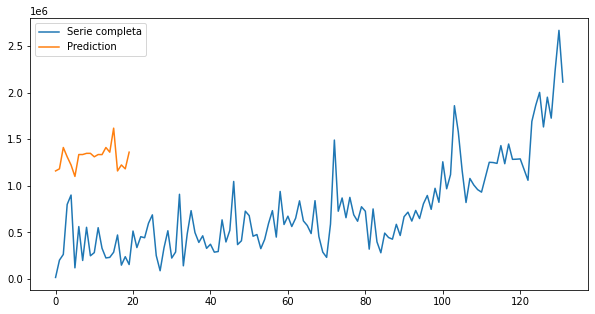

In [47]:
plt.figure(figsize=(10,5))
plt.plot(data['total_amount_claims'],label = 'Serie completa')
plt.plot(y_pred, label = 'Prediction')
plt.legend(loc='best')
plt.show()

In [48]:
data_orig = pd.read_excel('../raw_data/weekly_data_clean.xlsx', engine='openpyxl')

In [50]:
data_orig = data_orig.drop(columns='Unnamed: 0')

In [51]:
data_orig

,date_issue,total_amount_claims
0,2018-09-03,16683
1,2018-09-10,201774
2,2018-09-17,263661
3,2018-09-24,799703
4,2018-10-01,900305
...,...,...
127,2021-02-08,1949930
128,2021-02-15,1725225
129,2021-02-22,2232202
130,2021-03-01,2666662


In [54]:
data['total_amount_claims'].index = pd.to_datetime(data_orig.iloc[:, 0]) #relaciona indices

In [58]:
data['total_amount_claims'].reset_index()

,date_issue,total_amount_claims
0,2018-09-03,16683.0
1,2018-09-10,201774.0
2,2018-09-17,263661.0
3,2018-09-24,799703.0
4,2018-10-01,900305.0
...,...,...
127,2021-02-08,1949930.0
128,2021-02-15,1725225.0
129,2021-02-22,2232202.0
130,2021-03-01,2666662.0


In [65]:
data['y_pred'] = pd.DataFrame(y_pred)
data[['y_pred']]

,y_pred
0,1.158975e+06
1,1.181255e+06
2,1.410299e+06
3,1.310582e+06
4,1.222971e+06
...,...
127,NaN
128,NaN
129,NaN
130,NaN


In [63]:
len_ = int(0.8*data.shape[0])
len_
# data_train = data[:len_]
# data_test = data[len_:]

105

In [67]:
data[['y_pred']].index = pd.to_datetime(data_orig.iloc[105:, 0])

ValueError: Length mismatch: Expected axis has 132 elements, new values have 27 elements